In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple
import math
from dataclasses import dataclass

### 原始的MLA算法

### 1. 前置函数：RMSNorm，ROPE

In [ ]:
class DeepseekV2RMSNorm(nn.Module):
    def __init__(self, hidden_size, eps = 1e-6):
        super().__init__()
        # shape (hidden_size, 1)
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states):
        # 初始化精度，因为RMSNorm是f32的精度计算
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        # hidden_states shape (batch_size, seq_len, num_head, head_dim)
        # shape (batch_size, seq_len, num_head, 1)
        variance = hidden_states.pow(2).mean(-1, keepdim=True)
        # 广播，在最后一维 上乘 rsqrt 等价于平方根的倒数，就是 1/ sqrt(var^2 + eps)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon)
        
        # 广播得到的 shape (batch_size, seq_len, num_head, head_dim)
        return self.weight * hidden_states.to(input_dtype)

In [30]:
class DeepseekV2RotaryEmbedding(nn.Module):
    def __init__(self, dim, max_position_embeddings = 2048, base = 10000, device = None):
        super().__init__()
        
        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        inv_freq = 1.0 / (
            self.base ** (torch.arange(0, self.dim, 2).float().to(device) / self.dim)
        )
        # inv_freq shape is (head_dim // 2, )
        self.register_buffer('inv_freq', inv_freq, persistent = False)
        # 较小的索引位置对应较低的频率，较大的索引位置有较高的频率

        self._set_cos_sin_cache(
            seq_len = max_position_embeddings,
            device = self.inv_freq.device,
            dtype = torch.get_default_dtype()
        )
        self.max_seq_len_cached = None

    def _set_cos_sin_cache(self, seq_len, device, dtype):
        self.max_seq_len_cached = seq_len
        
        # t shape (seq_len, )
        t = torch.arange(
            self.max_seq_len_cached, device = device, dtype=self.inv_freq.dtype
        )

        # (seq_len, head_dim // 2)
        freqs = torch.outer(t, self.inv_freq.to(t.device))

        # cos, sin (seq_len, head_dim)
        emb = torch.cat((freqs, freqs), dim = -1)
        self.register_buffer("cos_cached", emb.cos().to(dtype), persistent=False)
        self.register_buffer("sin_cached", emb.sin().to(dtype), persistent=False)

    def forward(self, x, seq_len = None):
        # x shape (batch_size, num_head, seq_len, head_dim)
        if self.max_seq_len_cached is None or self.max_seq_len_cached < seq_len:
            self._set_cos_sin_cache(seq_len = seq_len, device=x.device, dtype=x.dtype)

        return (
            self.cos_cached[:seq_len].to(dtype=x.dtype),
            self.sin_cached[:seq_len].to(dtype=x.dtype)
        )

def rotated_half(x):
    ''' Rotates half the hidden dims of the input'''
    # x shape (batch_size, num_head, seq_len, head_dim)
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim = -1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids, unsqueeze_dim = 1):
    # position_ids shape (batch_size, seq_len)
    # cos, sin shape (seq_len, head_dim) ->(batch_size, 1, seq_len, head_dim)
    # 注意！tensor2[tensor1]的时候，shape是 (tensor1.shape[0], tensor1.shape[1], temsor2.shape[1], ...)
    cos = cos[position_ids].unsqueeze(unsqueeze_dim)
    sin = sin[position_ids].unsqueeze(unsqueeze_dim)

    # 最后一个维度进行特征重排
    '''
    假设q最后一个维度的元素为 [a, b, c, d](即d=4, d//2=2)

    第一步view后: 拆分为 [[a, b], [c, d]](形状(2, 2))
    第二步transpose后: 交换维度为 [[a, c], [b, d]](形状(2, 2))
    第三步reshape后: 合并为 [a, c, b, d](恢复d=4) 
    '''
    batch_size, num_head, seq_len, head_dim = q.size()
    q = q.view(batch_size, num_head, seq_len, head_dim // 2, 2).transpose(4,3).reshape(batch_size, num_head, seq_len, head_dim)

    batch_size, num_head, seq_len, head_dim = k.size()
    k = k.view(batch_size, num_head, seq_len, head_dim // 2, 2).transpose(4,3).reshape(batch_size, num_head, seq_len, head_dim)

    # q, k shape (batch_size, num_head, seq_len, head_dim)
    # cos, sin shape (batch_size, 1, seq_len, head_dim)
    q_embd = (q * cos) + (rotated_half(q) * sin)
    k_embd = (k * cos) + (rotated_half(k) * sin)
    return q_embd, k_embd


In [31]:
a = torch.tensor([1, 2, 3, 4, 5, 6])
b = a.view(2, 3).transpose(-1, -2).reshape(6)
print(a)
print(b)

tensor([1, 2, 3, 4, 5, 6])
tensor([1, 4, 2, 5, 3, 6])


In [32]:
# shape (3, 3)
position_ids = torch.tensor([
    [0, 1, 1],  # 第一个序列的位置
    [1, 2, 2],   # 第二个序列的位置
    [0, 0, 0]
]) 
# shape (3, 4)
cos = torch.tensor([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12]
])
print(cos[position_ids].shape, cos[position_ids])

torch.Size([3, 3, 4]) tensor([[[ 1,  2,  3,  4],
         [ 5,  6,  7,  8],
         [ 5,  6,  7,  8]],

        [[ 5,  6,  7,  8],
         [ 9, 10, 11, 12],
         [ 9, 10, 11, 12]],

        [[ 1,  2,  3,  4],
         [ 1,  2,  3,  4],
         [ 1,  2,  3,  4]]])


In [33]:
# shape (3, 3)
position_ids = torch.tensor([
    [0, 1, 1],  # 第一个序列的位置
    [1, 2, 2],   # 第二个序列的位置
    [0, 0, 0]
]) 
# shape (3, 4, 4)
cos = torch.tensor([
    [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 10, 11, 12],
        [9, 10, 11, 12]
    ],
    [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 10, 11, 12],
        [9, 10, 11, 12]
    ],
    [
        [1, 2, 3, 4],
        [5, 6, 7, 8],
        [9, 10, 11, 12],
        [9, 10, 11, 12]
    ]
    
])
print(cos.shape)
print(cos[position_ids].shape, cos[position_ids])

torch.Size([3, 4, 4])
torch.Size([3, 3, 4, 4]) tensor([[[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [ 9, 10, 11, 12]],

         [[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [ 9, 10, 11, 12]],

         [[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [ 9, 10, 11, 12]]],


        [[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [ 9, 10, 11, 12]],

         [[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [ 9, 10, 11, 12]],

         [[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [ 9, 10, 11, 12]]],


        [[[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [ 9, 10, 11, 12]],

         [[ 1,  2,  3,  4],
          [ 5,  6,  7,  8],
          [ 9, 10, 11, 12],
          [ 9, 10, 11, 12]],

         [[ 1,  2,  3,  4],
         

In [34]:
def test_rope():
    batch_size, seq_len, num_head, head_dim = 8, 4, 6, 8
    q = torch.randn(batch_size, num_head, seq_len, head_dim)
    k = torch.randn(batch_size, num_head, seq_len, head_dim)
     # 创建位置ID (可以是任意位置，不一定是连续的)
    # 这里使用连续位置: [[0,0,0,0], [1,1,1,1], ...] (seq_len, batch_size)
    position_id = torch.arange(seq_len).unsqueeze(1).repeat(1, batch_size).transpose(0, 1)

    rotary_emb = DeepseekV2RotaryEmbedding(dim=head_dim, max_position_embeddings = seq_len)
    # 预计算位置编码
    cos, sin = rotary_emb(q, seq_len = seq_len)  # shape: (seq_len, dim)
    q_rotated, k_rotated = apply_rotary_pos_emb(q, k, cos, sin, position_id)

    print("应用旋转位置编码后 - q_rotated形状:", q_rotated.shape)
    print("应用旋转位置编码后 - k_rotated形状:", k_rotated.shape)

test_rope()

应用旋转位置编码后 - q_rotated形状: torch.Size([8, 6, 4, 8])
应用旋转位置编码后 - k_rotated形状: torch.Size([8, 6, 4, 8])


### 实现MLA的代码

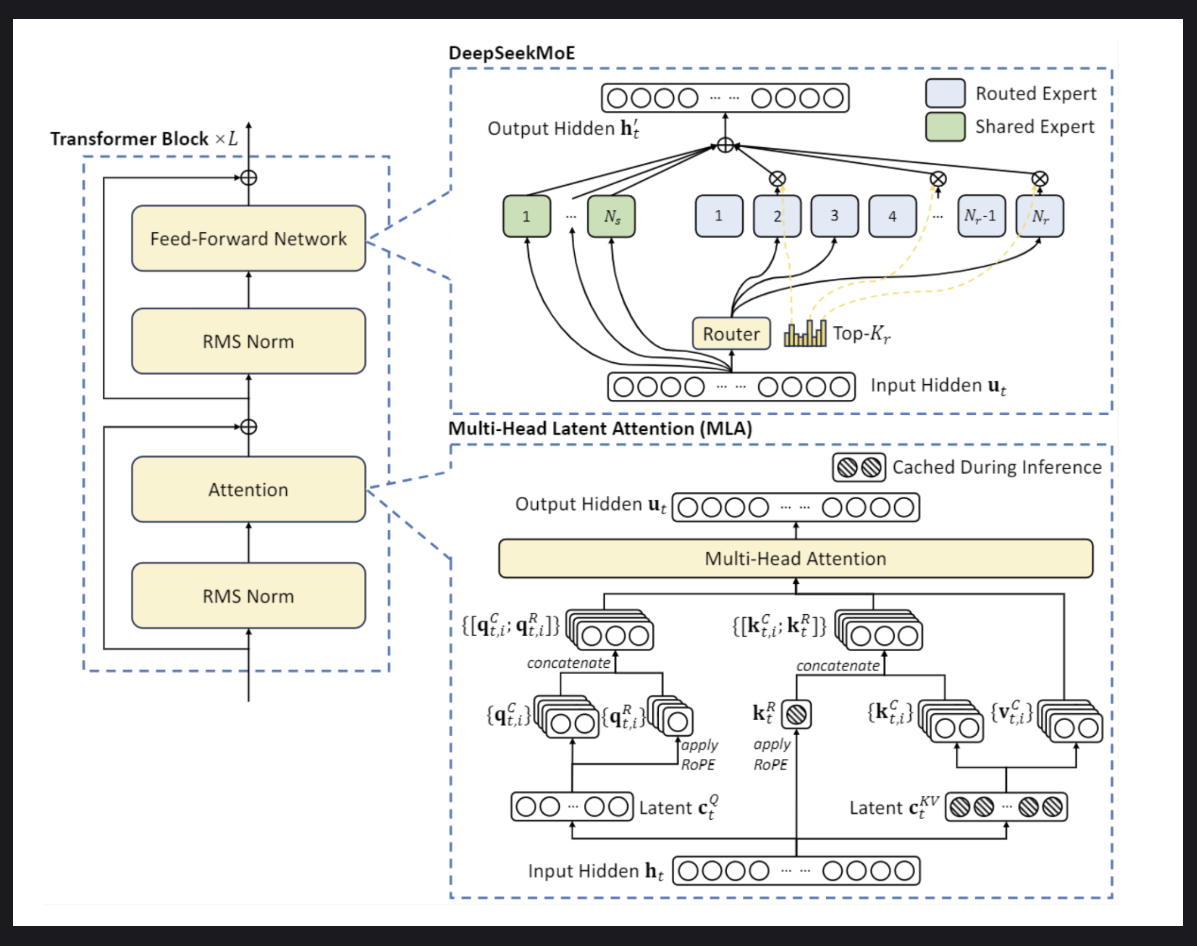

In [35]:
@dataclass
class DeepseekConfig:
    hidden_size: int
    num_heads: int
    max_position_embeddings: int    # rope
    rope_theta:float    # 频率，设置比较大

    attention_dropout:float

    # q_lora和kv_lora是低秩投影，qk_rope和qk_nope是head_dim
    q_lora_rank: int    # latent_shape，一般设置大一些: 10000+
    qk_rope_head_dim: int   # 64

    # 注意这里只有qk要rope，v不需要rope
    kv_lora_rank: int   # 可能是512
    v_head_dim: int     # 128
    
    qk_nope_head_dim: int   # 128
    attention_bias: bool    # 是否使用bias

class MLA(nn.Module):
    def __init__(self, config):
        super().__init__()
        # part 1: MHA部分

        self.attention_dropout = config.attention_dropout
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_heads
        self.v_head_dim = config.v_head_dim

        self.out_proj = nn.Linear(
            self.num_heads * self.v_head_dim,
            self.hidden_size,
            bias = False    # 可加可不加
        )

        # 最重要的是 part 2：MLA压缩部分
        # p2.1 down压缩
        self.qk_nope_head_dim = config.qk_nope_head_dim
        self.qk_rope_head_dim = config.qk_rope_head_dim


        # q 一般会从 7168 -> 1536，压缩比是 1/4.7，图中对应为 latent c_t^Q
        self.q_lora_rank = config.q_lora_rank
        
        # 图中对应为 latent c_t^{KV}
        self.kv_lora_rank = config.kv_lora_rank

        self.q_down_proj = nn.Linear(
            self.hidden_size,
            self.q_lora_rank,
            bias = config.attention_bias
        )
        # 这里是初始化实例，传入秩
        self.q_down_norm = DeepseekV2RMSNorm(self.q_lora_rank)

        # qk_rope_head_dim 设置比较小 64
        self.kv_down_proj = nn.Linear(
            self.hidden_size,
            self.kv_lora_rank + config.qk_rope_head_dim,    # qk_rope_head_dim 对应图中的 k_t^R
            bias = config.attention_bias
        )
        # kv_down_norm包含了两个部分，要做split
        self.kv_down_norm = DeepseekV2RMSNorm(self.kv_lora_rank)

        
        # p2.2 升维
        # 注意！kv是在降维的时候得到了rope矩阵，而q是在升维的部分得到的rope
        # q and k shape is same
        self.q_head_dim = config.qk_nope_head_dim + config.qk_rope_head_dim

        self.q_up_proj = nn.Linear(
            self.q_lora_rank, 
            self.num_heads * self.q_head_dim,
            bias = config.attention_bias
        )   # 这里也要split 

        self.qk_nope_dim = config.qk_nope_head_dim
        self.kv_up_proj = nn.Linear(
            self.kv_lora_rank,
            self.num_heads * (
                self.q_head_dim - config.qk_rope_head_dim + self.v_head_dim
            # self.q_head_dim - config.qk_rope_head_dim = k_nope_shape
            ),
            bias = config.attention_bias  
        )


        # part 3. ROPE位置编码部分
        self.rotary_emb = DeepseekV2RotaryEmbedding(
            config.qk_rope_head_dim,
            config.max_position_embeddings,
            config.rope_theta
        )

    def forward(self, hidden_states, position_ids, attention_mask = None):
        # hidden_states shape (batch_size, seq_len, hidden_dim)
        batch_size, q_len, _ = hidden_states.size()

        # 1. down proj / compression
        # q shape (batch_size, seq_len, q_lora_rank)
        q = self.q_down_proj(
            hidden_states
        )
        
        q = self.q_down_norm(q)
        # q shape (batch_size, seq_len, num_heads * (qk_nope + qk_ rope))
        q = self.q_up_proj(q)

        # q shape (batch_size, num_heads, seq_len, qk_nope + qk_rope)
        q = q.view(batch_size, q_len, self.num_heads, self.q_head_dim).transpose(1,2)
        
        q_nope, q_rope = torch.split(
            q,
            [self.qk_nope_head_dim, self.qk_rope_head_dim],
            dim = -1
        )

        # kv part
        # c_kv shape (batch_size, seq_len, kv_lora_rank + qk_rope)
        c_kv = self.kv_down_proj(hidden_states)
        c_kv, k_rope = torch.split(
            c_kv,
            [self.kv_lora_rank, self.qk_rope_head_dim],
            dim = -1
        )

        # k_rope shape (batch_size, 1, seq_len, qk_rope)
        k_rope = k_rope.view(
            batch_size, q_len, 1, self.qk_rope_head_dim
        ).transpose(1, 2)   # 这里可以做广播的

        # kv shape (batch_size, seq_len, kv_lora_rank)
        kv = self.kv_down_norm(c_kv)
        # kv shape (batch_size, seq_len, num_heads * (qk_nope_dim + v_head_dim))
        kv = self.kv_up_proj(kv)

        # kv shape (batch_size, num_heads, seq_len, qk_nope_dim + v_head_dim)
        kv = kv.view(
            batch_size, q_len, self.num_heads, self.qk_nope_dim + self.v_head_dim
        ).transpose(1, 2)
        
        # value_states shape (batch_size, num_heads, seq_len, v_head_dim)
        k_nope, value_states = torch.split(
            kv,
            [self.qk_nope_head_dim, self.v_head_dim],
            dim = -1
        )

        # apply ROPE位置编码
        kv_seq_len = value_states.shape[-2]
        
        # 这里传入value_states其实只用到了q_len这一个东西，qkv都是的
        cos, sin = self.rotary_emb(
            value_states, seq_len = kv_seq_len
        )

        q_rope, k_rope = apply_rotary_pos_emb(
            q_rope, k_rope, cos, sin, position_ids,
        )

        # MHA 
        # query_states shape (batch_size, num_heads, seq_len, qk_nope_dim + qk_rope_dim)
        query_states = torch.concat(
            [q_nope, q_rope], dim = -1
        )
        # key_states shape (batch_size, num_heads, seq_len, qk_nope_dim + qk_rope_dim)
        key_states = torch.concat(
            [k_nope, k_rope.expand(-1, self.num_heads, -1, -1)], dim = -1
        )
        
        attn_weight = torch.matmul(
            query_states, key_states.transpose(-1, -2)
        )
        # 这里q_head_dim 是nope+rope
        attn_weight = attn_weight / math.sqrt(self.q_head_dim)

        if attention_mask is not None:
            # causal mask
            attention_mask = attention_mask.tril()
            attn_weight = torch.masked_fill(
                attn_weight,
                attention_mask == 0, float('-inf')
            )

        # softmax 和 output proj
        attn_weight = F.softmax(
            attn_weight, dim = -1
        ).to(query_states.dtype)

        attn_weight = F.dropout(
            attn_weight, p = self.attention_dropout,
            training=self.training
        )

        # attn_weight shape (batch_size, num_heads, seq_len, seq_len)
        # value_states shape (batch_size, num_heads, seq_len, v_head_dim)
        output = torch.matmul(
            attn_weight, value_states
        )

        output = output.transpose(1, 2).contiguous()

        # shape (batch_size, seq_len, v_dim * num_heads)
        output = output.view(batch_size, q_len, -1)
        # shape (batch_size, seq_len, hidden_size)
        output = self.out_proj(output)

        return output,attn_weight


In [36]:
# 写一个测试函数
def test_mla():
    config = DeepseekConfig(
        hidden_size=7168,
        num_heads=16,
        max_position_embeddings=1024,
        rope_theta=128000,
        attention_dropout=0.1,
        q_lora_rank=1536,
        qk_rope_head_dim=64,
        kv_lora_rank=512,
        
        v_head_dim=128,
        qk_nope_head_dim=128,
        attention_bias=False,
    )

    mla = MLA(config)
    x = torch.randn(2, 1024, 7168)
    position_ids = torch.arange(
        config.max_position_embeddings,
    ).unsqueeze(0).expand(
        x.size(0), -1
    )
    attn_output, attn_weights = mla(x, position_ids=position_ids)
    print(attn_output.shape)
    print(attn_weights.shape)


test_mla()

torch.Size([2, 1024, 7168])
torch.Size([2, 16, 1024, 1024])
